# Small Project
This notebook will be our report.

# Data analysis

### Dataloader and Input Sampling

We use a common dataloader for all datasets.

There are 9 combinations (train, test, val) crossed with (the triclass classification and two binary classifiers). Therefore, it makes sense to create a class to generalise the possible dataloaders that we need.

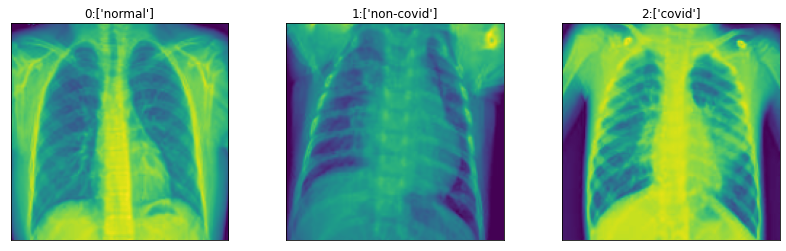

In [3]:
from lung_dataset import Lung_Dataset
ld_train = Lung_Dataset("test", "normal/non-covid/covid")
ld_train.show_imgs([0, 301, -1])

### Class distribution
We present the class distribution in a pie chart so that we can visualise the differences in the relative proportion.

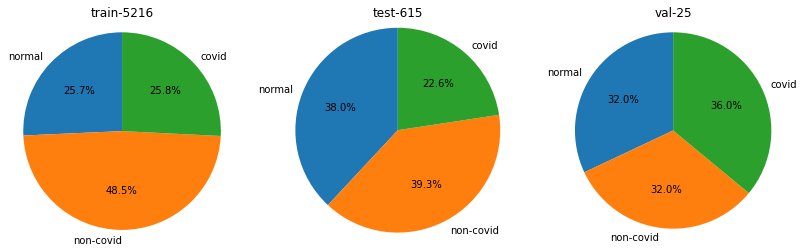

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=3, nrows=1, squeeze=False, figsize=(14,4))
for i,data_split in enumerate(["train", "test", "val"]):

    ld = Lung_Dataset(data_split, "normal/non-covid/covid")
    labels = [class_[0] for class_ in ld.classes]
    sizes = ld.class_distbn

    ax[0][i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax[0][i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[0][i].set_title("{}-{}".format(data_split, sum(sizes)))

plt.show()

We also did a visualisation of the distribution in the bar chart format as listed in the homework.

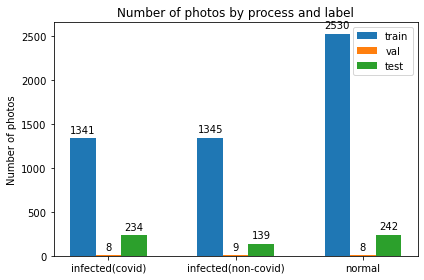

In [3]:
import os, os.path
import numpy as np
dataset_paths = {'train_normal': './dataset/train/normal/',\
                 'train_infected_covid': './dataset/train/infected/covid',\
                 'train_infected_noncovid': './dataset/train/infected/non-covid',\
                 'val_normal': './dataset/val/normal/',\
                 'val_infected': './dataset/val/infected/covid',\
                 'val_infected_noncovid': './dataset/val/infected/non-covid',\
                 'test_normal': './dataset/test/normal/',\
                 'test_infected': './dataset/test/infected/covid',\
                 'test_infected_noncovid': './dataset/test/infected/non-covid'}
number_photos_path={}
for path in dataset_paths.values():
    number_photos_path[path]=len([name for name in os.listdir(path)])
regroup_labels={}
label_name=[]
for path,val in number_photos_path.items():
    p = path.split("/")
    if p[-2] != "normal":
        name_label= "{}({})".format(p[-2],p[-1])
    else:
        name_label=p[-2]
    label_name.append(name_label)
    if p[-3] in regroup_labels.keys():
        regroup_labels[p[-3]].append(val)
    else:
        regroup_labels[p[-3]]=[val]
group_labels = set(label_name)
x = np.arange(len(group_labels)) 
width = 0.2  

def autolabel(rects,offset):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
fig, ax = plt.subplots()
offset=0
for process,val in regroup_labels.items():
    rects = ax.bar(x - width/2*2 + width*offset, val, width, label=process)
    autolabel(rects,offset)
    offset+=1


ax.set_ylabel('Number of photos')
ax.set_title('Number of photos by process and label')
ax.set_xticks(x)
ax.set_xticklabels(group_labels)
ax.legend()
fig.tight_layout()
plt.show()

# Preprocessing

### Data augmentation

We apply random rotation in our data augmentation. X-ray are not always taken vertically, as we noticed that some of the images are slightly rotated. Random rotation between -5 to 5 degrees will simulate such a variation.

Adding randomness in the training data helps to tackle overfitting. It was observed that after data augmentation, for models without dropout, the training accuracy no longer approaches near 100%.

We have considered the following data augmentation methods and decided not to apply them, and the reasons are justified as such
- Noising. We might want the model to detect specks in the X-rays, and noising may cause this feature to be undetectable.
- Random cropping. We tried this and it resulted in predictions that are hardly better than random.
- Flipping. The X-ray is not exactly symmetrical due to the placement of the heart, we do not want to train the model to be agnostic to the orientation.


### Data processing

We crop and resize for both our training and testing set. The center 140 pixels are cropped, and then resized back to 150 pixels. The purpose is to exclude the misfited pixels due to the rotation operation. Moreover, whether the lung is infected should not depend on the pixels at the border as the position of the lung is in the middle of the picture.

The latter resizing operation is actually unnecessary, but we retained it for the ease of development. We want to standardise the dimensions of our input to be the same as our original dataset.


### Data Normalisation

From the sample code, the 8-bit picture was scaled down to a value of between 0 and 1. We calculated the mean and standard deviation of the dataset, which was 0.482 and 0.236. With the mean and standard deviation, we apply normalisation transformation to all data splits.

Normalising the input is said to help to train the model [faster](https://stackoverflow.com/questions/4674623/why-do-we-have-to-normalize-the-input-for-an-artificial-neural-network).

### Full Preprocessing Step


```python
        if self.data_split == "train":
            transform = transforms.Compose([
                transforms.RandomRotation((-5,5)),
            ])
            im = transform(im)
            
        transform = transforms.Compose([
                transforms.CenterCrop((140)),
                transforms.Resize((150)),
            ])
        im = transform(im)

        im = transforms.Normalize(mean=0.482, std=0.236)(im)
```


The normalisation is executed after the rotation. We decided this order because we want the misfitted pixels (if there is remaining) resulting from the rotation to remain dark.

train


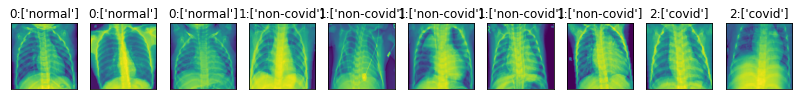

test


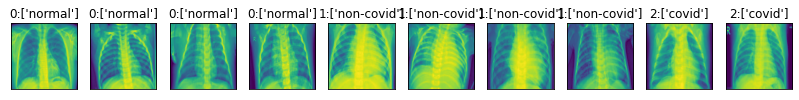

In [4]:
from lung_dataset import Lung_Dataset
print("train")
ld_train = Lung_Dataset("train", "normal/non-covid/covid")
ld_train.show_imgs(range(0,5000,500))

print("test")
ld_train = Lung_Dataset("test", "normal/non-covid/covid")
ld_train.show_imgs(range(0,660,66))

# Model Design

We will now explain our model design. We initially decided on some model design parameters such as our loss function and the choice of overall architecture.

### Loss Function - Cross Entropy Loss (to tired to write a better explanation)

We chose to use the Cross Entropy Loss as the outputs are mutually exclusive (i.e someone who is normal cannot have covid and vice-versa). Using a softmax layer to produce the probabilities for each class models the mutually exclusive property.

### Two binary classifier instead of triclass classifier

The problem statement proposed two ways that we can train our model 
- a single tri class classifier classifying between normal/non-covid/covid
- two binary classifiers, with the first classifying between normal/infected and the second classifier classifying non-covid/covid

We decided to focus only on two binary classifiers as each classifier would be able to learn more features relevant to the two classes rather than learning lesser features per class when it tries to accomodate all three classes. When comparing the accuracy of both tri class classifier and binary classifier for 10 epochs before fine tuning parameters, both models returned similar accuracy.

#### Model architecture

We used VGG18 as a guide for our custom model, by following the general design of VGG18 and reducing the number of output channels to suit the number of classes we are predicting. Each block in the net consists of 2 convolutional layers with 3x3 kernel, followed by a ReLU function after each convolutional layer before conducting batch normalization and a max pooling of 2x2 with a stride of 2. To end it off, there are 3 fully connected layers, with 2 drop out layers in between. Below is a snapshot of our 8 layers architecture.

In [5]:
from functions import Net
visualize_model = Net()
print(visualize_model)

Net(
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
  (conv1_): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2_): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv3_): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv4_): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=200, out_features=200, bias=True)
  (fc1): Linear(in_fea

There is a tradeoff of having a model with a larger number of parameters. A general rule of thumb for machine learning is that the number of parameters should be less than the amount of dataset. Our training dataset is of size 5856 pictures. 

We decided to try out different numbers of convolutional layers in Net. By changing the number of convolutional layers, we change the scale at which the model views the images as well as the number of parameters within the model. Thus by testing the 4 to 8 layers for each classifier, we can find the best suited number of layers to be used for each classification task. Below are the models we investigate.

Net(8 conv layers, number of parameters: 45348), Net2(6 conv layer, number of parameters: 275348), Net4(4 conv layer, number of parameters: 930148)

#### Mini-batch size

We vary the batch-size from the set **{8, 16, 20}** to allow for batch-normalisation.

A mini-batch too small
- Results in slower training as more computations could be done in parallel
- Batch normalisation does not work for small mini-batches

A mini-batch too large
- The GPU may not have sufficient memory
- Gradients are updated too slowly

#### Optimizer and learning rate

We chose to use Adam optimiser as it comes with Root Mean Square Propogation which updates the gradients based on the average of the recent gradients for weights (ie. it will reduce the gradient learning rate if the gradient has been increasing at an increasing rate and increase the gradient learning rate if the gradient is in the flat part of the graph).

The range of learning rates we will be varying are: **{0.001, 0.005, 0.0001, 0.0005}**

A learning rate too large may not converge, a learning rate too small converges too slowly.

#### Others

##### Regularisation
We chose to vary dropout rate to prevent overfitting. Varying from the set of probabilities **{0.1, 0.25, 0.5, 0.76, 0.9}**. Setting a dropout parameter randomly sets a weight to 0 with probability p, this can help to prevent all the weights from synchronously optimising their parameters and cause overfitting.

##### Weights Initialisation
We initialised our model with batch size 20 and learning rate 0.001. We chose our batch size and learning rate based on the paper **Deep-COVID: Predicting COVID-19 from chest X-ray images using deep transfer learning** which works with a similar dataset.

### Finetuning the Model
We created a new performance metric, weighted_accuracy, which helps to evaluate the model with an emphasis on the recall of the covid class. This is because, it is better to predict that the person has covid even if the person does not have covid as compared to predicting the person does not have covid when the person does has covid. By doing so, we can reduce the spread of covid cases by identifying as many covid cases as we can but at the same time, we do not want to overwhelm hospitals by predicting every person to have covid. Thus, we aim for a weighted average of accuracy and recall of the covid class. For the case of the normal/infected classifier, the weighted accuracy will be the weighted average of accuracy and the recall of the infected class.

Specifically, the way weighted_accuracy is calculated in the model classifying covid vs non-covid is **weighted_accuracy = 0.8 * accuracy + 0.2 * covid_recall**. While for the model classifying normal vs infected weighted_accuracy is calculated as **weighted_accuracy = 0.8 * accuracy + 0.2 * infected_recall**.

### Experimentation on model architecture

Below we show the graphs comparing the difference between 6 and 8 layers architecture for the normal/infected classifier and the 4 and 6 layers architecture for the covid/non-covid classifier

#### Normal vs Infected 8 layers net

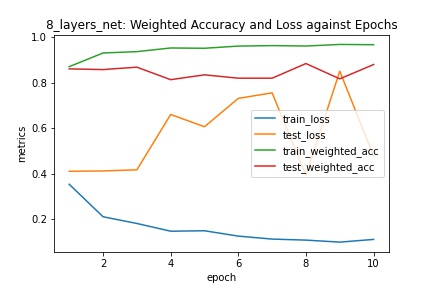

In [6]:
# Normal vs Infected 8 layers binary classifier
from IPython.display import Image
Image(filename='plots/8_layers_net.jpg') 

#### Normal vs Infected 6 layers net

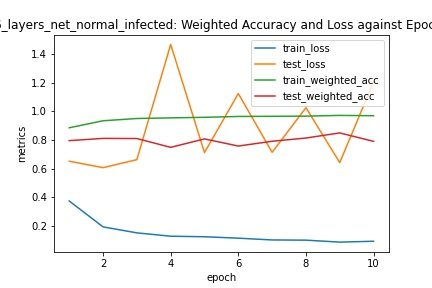

In [7]:
# Normal vs Infected 6 layers binary classifier
from IPython.display import Image
Image(filename='plots/6_layers_net_normal_infected.jpg') 

As seen from the graphs above, for the normal/infected classification, 8 layers performed better than 6 layers as the fluctuations in test accuracy is lower. Thus, the 8 layers model was used for further hyperparameter fine tuning. It is also noted that both models tend to overfit the training set.

#### Covid vs Non-Covid 8 layers net

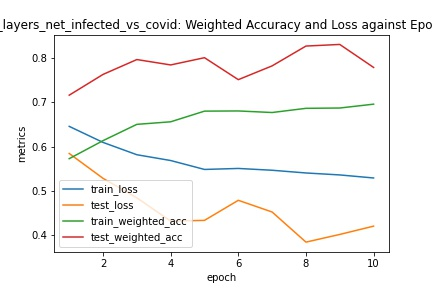

In [17]:
# Covid vs Non-Covid 6 layers binary classifier
from IPython.display import Image
Image(filename='plots/8_layers_net_infected_vs_covid.jpg') 

#### Covid vs Non-Covid 6 layers net

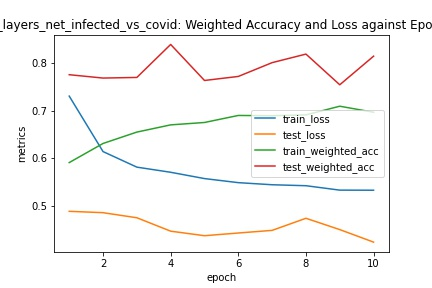

In [8]:
# Covid vs Non-Covid 6 layers binary classifier
from IPython.display import Image
Image(filename='plots/6_layers_net_infected_vs_covid.jpg') 

#### Covid vs Non-Covid 4 layers net

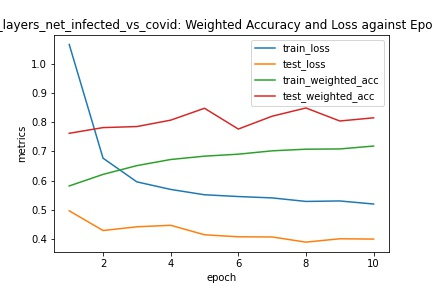

In [9]:
# Covid vs Non-Covid 4 layers binary classifier
from IPython.display import Image
Image(filename='plots/4_layers_net_infected_vs_covid.jpg') 

For the covid/non-covid classification, 6 layers performed better than 8 layers and subsequently 4 layers performed better than 6 layers in terms of weighted accuracy. Thus, the 4 layers model was used for further hyperparameter fine tuning. 

### Hyperparameters Search

We use grid search to find the best combination of the model hyperparameters for each binary classifier.

We select multiple combinations of hyperparameters that fulfil the expected look of the graph where the train loss and test loss are following a decreasing trend and the train and test accuracy are increasing asypmtopically to 1.

The selected models are:
   1. Normal vs Infected: learning_rate = 0.0001, dropout = 0.9 , batch_size = 20
   2. Covid vs Non-Covid: learning_rate = 0.001, dropout = 0.1 , batch_size = 20

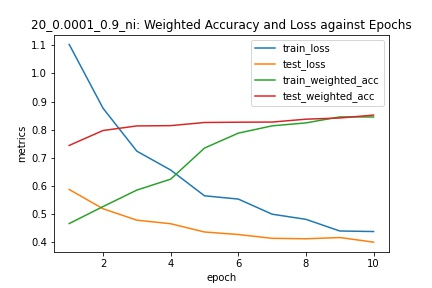

In [10]:
# Normal vs Infected binary classifier
from IPython.display import Image
Image(filename='plots/20_0.0001_0.9_ni.jpg') 

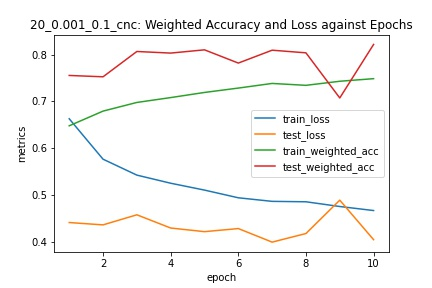

In [11]:
# Covid vs Non-Covid binary classifier
from IPython.display import Image
Image(filename='plots/20_0.001_0.1_cnc.jpg') 

The 2 models chosen above appear to be learning well for both the train set and the test set. With a weighted accuracy of 0.836 on the test set for the covid/non-covid classifier and a weighted accuracy of 0.852 on the test set for the normal/infected classifier. The original overfitting of the model for the normal/infected classifier also seems to disappear with a lower learning rate and high dropout probability. The model for the covid/non-covid classifier seems to be able to learn the features from the training set quick enough as well.

Thus, we took the model with the best performing weighted_accuracy for both classifiers and load it to run the combined classification on the visualization set.

Confusion matrix:
[[2 1 5]
 [0 1 7]
 [0 1 8]]
Val Accuracy: 0.44000 
Val covid recall 0.8888888888888888 
Weighted Accuracy: 0.5297777777777778
torch.Size([24, 1, 150, 150])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

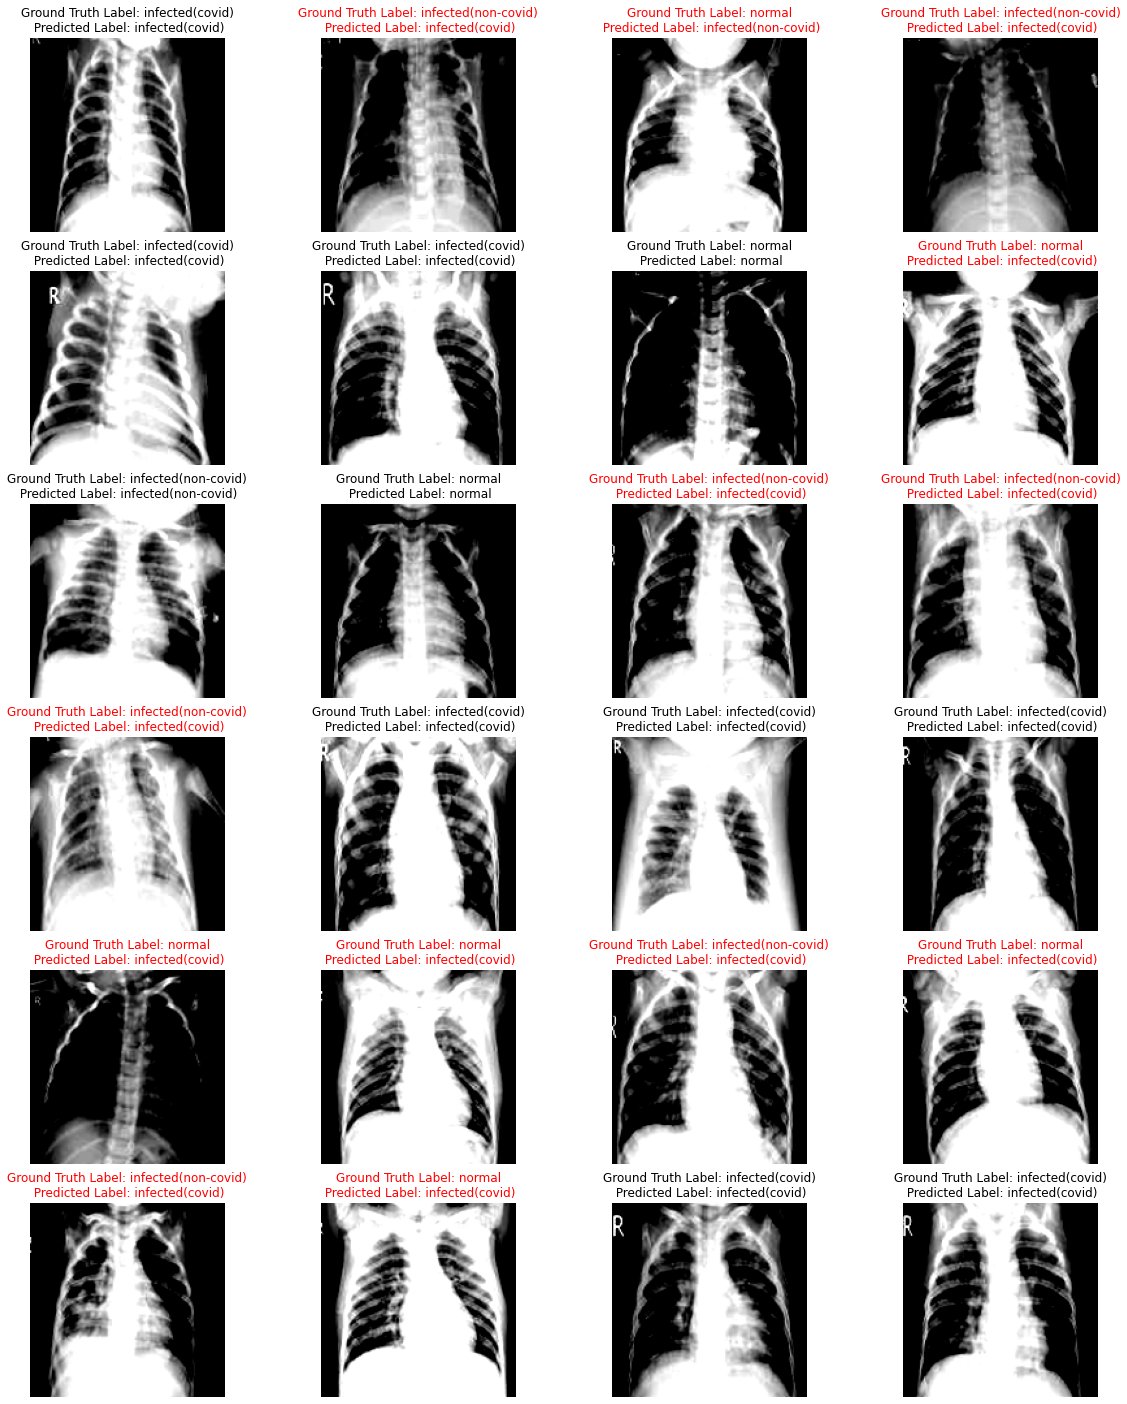

In [14]:
from functions import two_stage_testing, loader_fn
import torch
    
# Set device to use gpu if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define paths
val_loader_path = './dataloader/val_loader.pkl'
model1_path = "./actual_saved_models/20_0.0001_0.9_ni16:42:58.pth"
model2_path = "./actual_saved_models/20_0.001_0.1_cnc14:33:53.pth"

# Load models
first_model, second_model, valloader = loader_fn(val_loader_path, model1_path, model2_path)

# Run Evaluation
acc, recall, weighted_acc = two_stage_testing(valloader, first_model, second_model, device)

As can be seen above, the combined weighted accuracy of 0.53 is much lower compared to each of the binary classifier. We believe that the infected recall was given too much priority during the training of the normal/infected classifier resulting in a tendency to predict most images as infected and lowering the accuracy of the whole model. Thus, we chose to pick the model with the highest average of training and test loss as the new performance metric to search for the best normal/infected classifier model. Also, we chose to pick the model with the highest weighted accuracy on the test set for the covid/non-covid classifier. 

This results in the best set of parameters for the following classifiers to be:
   1. Normal vs Infected: learning_rate = 0.005, dropout = 0.75 , batch_size = 8
   2. Covid vs Non-Covid: learning_rate = 0.0005, dropout = 0.5 , batch_size = 16

Below we display the weighted accuracy and loss against epochs for:
Normal vs Infected: learning_rate = 0.005, dropout = 0.75 , batch_size = 8

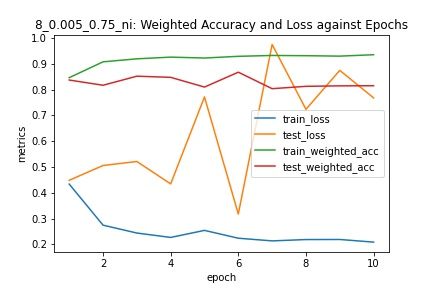

In [13]:
from IPython.display import Image
Image(filename='plots/8_0.005_0.75_ni.jpg') 

Below we display the weighted accuracy and loss against epochs for:
Covid vs Non-Covid: learning_rate = 0.0005, dropout = 0.5 , batch_size = 16

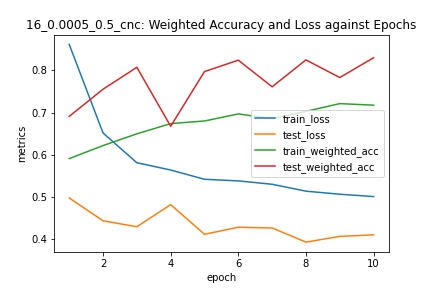

In [14]:
Image(filename='plots/16_0.0005_0.5_cnc.jpg') 

# Performance evaluation

### Visualisation on the validation set

We show how did we predict on the visualisation set

Confusion matrix:
[[6 0 2]
 [1 5 2]
 [0 1 8]]
Val Accuracy: 0.76000 
Val covid recall 0.8888888888888888 
Weighted Accuracy: 0.7857777777777779
torch.Size([24, 1, 150, 150])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

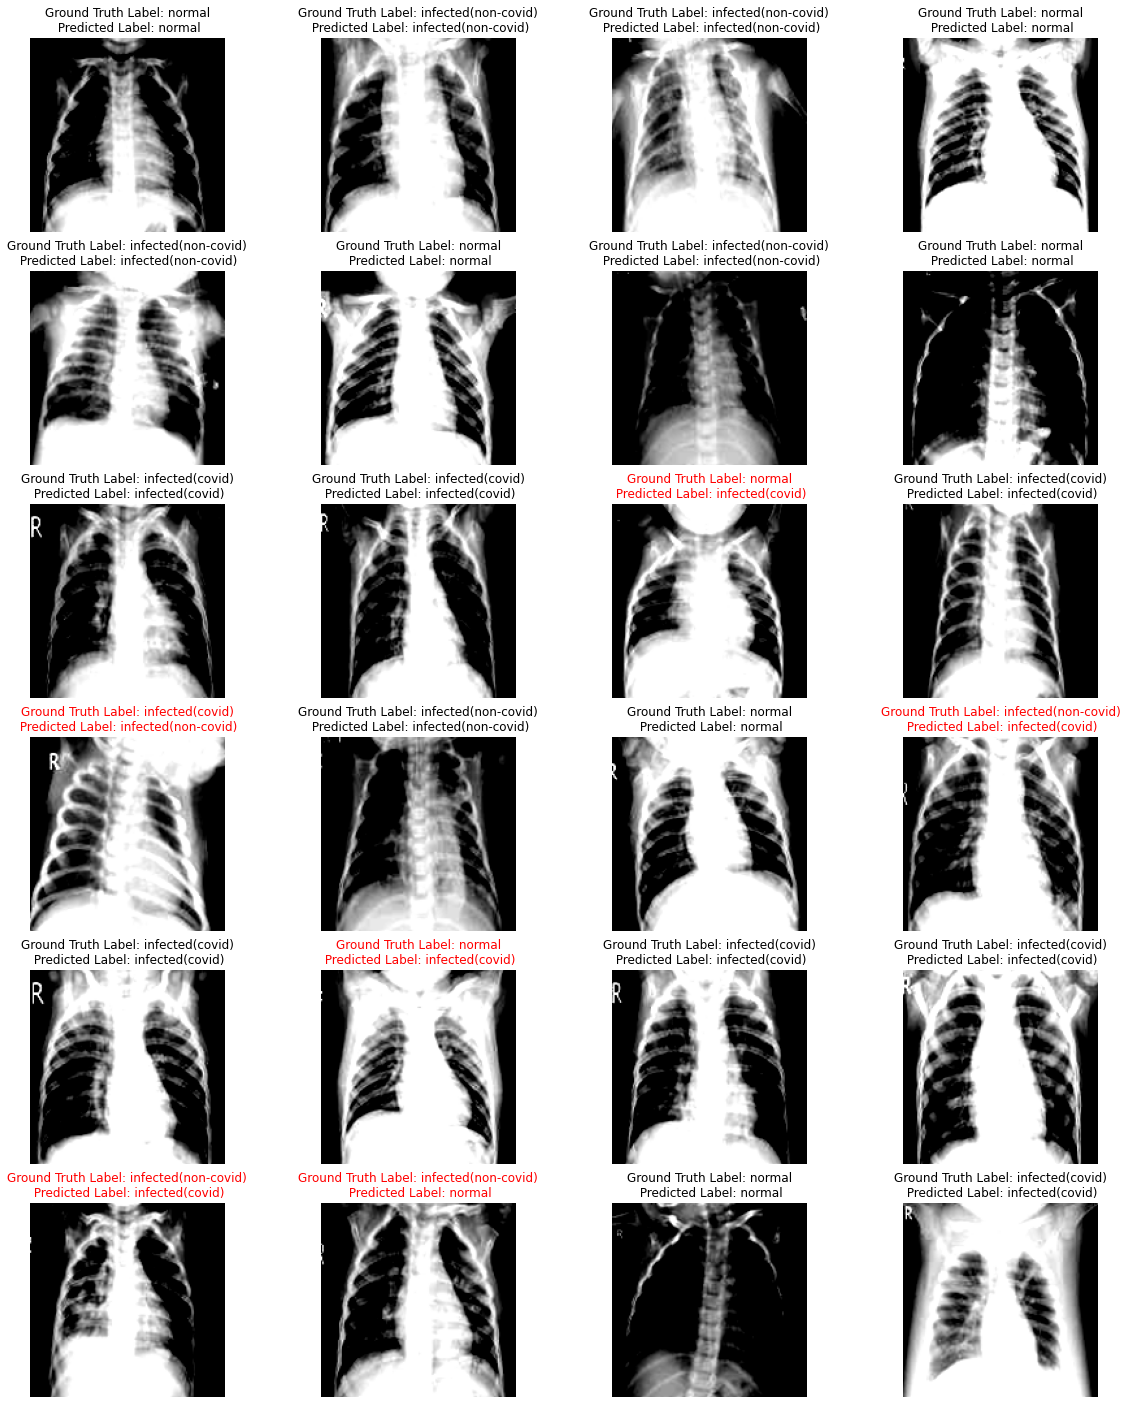

In [16]:
from functions import two_stage_testing, loader_fn
import torch

# Set device to use gpu if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define paths
val_loader_path = './dataloader/val_loader.pkl'
model1_path = "./actual_saved_models/8_0.005_0.75_ni12:09:55.pth"
model2_path = "./actual_saved_models/16_0.0005_0.5_cnc14:20:35.pth"

# Load models
first_model, second_model, valloader = loader_fn(val_loader_path, model1_path, model2_path)

# Run Evaluation
acc, recall, weighted_acc = two_stage_testing(valloader, first_model, second_model, device)

### Results and conclusions

This time, our combined model is able to obtain a better weighted accuracy of 0.786 which is closer to each of the individual weighted accuracy. This shows that having the normal/infected classifier perform unbiased prediction helps improve the overall performance of the combined model. Also, we have achieved the goal of maximizing the recall of the covid class by choosing the model with the highest weighted accuracy for the covid/non-covid classifier. As can be seen from the confusion matrix above, we were able to predict 8 out of 9 actual covid cases as covid, thereby maximizing the recall of the covid class.

### Future work and constraints

We have listed here some of the future work that could be done to improve the model's performance.
- Train for more epochs
    - Due to limited time to work on the project, we only had time to train models for 10 epochs. As a result, the binary classifier for covid vs non-covid was probably underfitting as the gradient of the training/testing loss is negative.
- Weighted random sampler in Dataloader
    - As the distribution of classes for train/test/validation was unequal, we were supposed to implement a weighted random sampler in the Dataloader such that when selecting samples for batch training, the distribution of samples for each class would fulfil that of the validation set. 

## Questions

1.**You might find it more difficult to differentiate between non-covid and covid x-rays, rather
than between normal x-rays and infected (both covid and non-covid) people x-rays. Was that
something to be expected? Discuss.**

It was something to be expected as the visual similarity between non-covid and covid would be higher as compared to a normal and covid x-ray. Also, the number of training samples for the normal and infected is higher than the covid and non-covid dataset as the covid and non-covid is a subset of the normal/infected dataset.

However, in our training, we have achieved a similar level of weighted accuracy for both our models. This is possibly due to accounting for the recall of infected as well as recall for covid. Perhaps the recall values increased the accuracy score in a similar way for both classifiers resulting in a similar level of weighted accuracy.

2.**Final question: would it be better to have a model with high overall accuracy or low true
negatives/false positives rates on certain classes? Discuss.**

It would be better to have a model with low false negatives for the binary classifier comparing covid vs non-covid as we would like to maximise the number of positive covid cases identified. It would be more preferable that a person not having covid was identified as a covid patient as compared to misidentifying someone with covid as a person who does not have covid.
